In [262]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro, boxcox, ttest_ind, mannwhitneyu, pearsonr, friedmanchisquare, kruskal, kstest, \
    lognorm, gamma, weibull_min, probplot, f_oneway, linregress, norm, spearmanr, ttest_1samp, wilcoxon 
import seaborn as sns
import os
import ast
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols, mixedlm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp
import itertools

In [263]:
input_dir = "Results" # input directory

number = "J" # results to analyze (subfolder name, can be an integer or string)

recording_order = (15, 2, 1, 6, 10, 4)

In [264]:
dfs = {}

results_dir = os.path.join(input_dir, str(number))
files = [file for file in os.listdir(results_dir) if file.endswith(('.xlsx', '.xls')) and not file.startswith('OVERVIEW')]

for file in files:
    file_path = os.path.join(results_dir, file)
    dfs[file.split('.')[0]] = pd.read_excel(file_path)

framenames = list(dfs.keys())
results = framenames[0]
results_mtt = framenames[1]
results_tt = framenames[2]

print(f"Found {framenames} in {results_dir}.")

framenames.append('RESULTS_MERGED')
framenames.append('RESUlTS_MERGED_MTT')
framenames.append('RESULTS_MERGED_TT')

Found ['RESULTS', 'RESULTS_MTT', 'RESULTS_TT'] in Results\J.


In [265]:
experiments = dfs[results]['experiment'].unique().tolist()
variables = dfs[results].columns[4:].tolist()
parameters = dfs[results].columns[:4].tolist()
print(f"Found {len(experiments)} experiments, {len(variables)} variables and {len(parameters)} parameters:")
print(" "+', '.join(experiments))
print(" "+', '.join(variables))
print(" "+', '.join(parameters))

Found 16 experiments, 7 variables and 4 parameters:
 tone_in_noise, gap_duration_4, gap_duration_8, gap_duration_10, gap_duration_20, gap_duration_50, offset_PPI_4, offset_PPI_6, offset_PPI_8, offset_PPI_10, offset_PPI_12, offset_PPI_14, offset_PPI_16, offset_PPI_18, offset_PPI_20, offset_PPI_50
 reactionTime, peakTime, difference, peakValue, RMS, tau, AUC
 animal, sex, date, experiment


In [266]:
def average_list_columns(df):
    df_copy = df.copy()
    for col in df_copy.columns:
        # Try to convert string representations of lists to actual lists
        if df_copy[col].apply(lambda x: isinstance(x, list) or (isinstance(x, str) and x.startswith('['))).any():
            df_copy[col] = df_copy[col].apply(
                lambda x: np.mean(ast.literal_eval(x)) if isinstance(x, str) and x.startswith('[') else np.mean(x) if isinstance(x, list) else x
            )
    return df_copy

# Create merged DataFrames with averaged values
dfs['RESULTS_MERGED'] = average_list_columns(dfs[results])
dfs['RESULTS_MTT_MERGED'] = average_list_columns(dfs[results_mtt])
dfs['RESULTS_TT_MERGED'] = average_list_columns(dfs[results_tt])

In [267]:
def average_across_dates(df):
    # Group by all columns except 'date' and the variables, then average variables across dates
    group_cols = [col for col in df.columns if col not in variables and col != 'date']
    averaged = df.groupby(group_cols, as_index=False)[variables].mean()
    return averaged

# Create merged DataFrames with averaged values
dfs['RESULTS_MERGED'] = average_list_columns(dfs[results])
dfs['RESULTS_MTT_MERGED'] = average_list_columns(dfs[results_mtt])
dfs['RESULTS_TT_MERGED'] = average_list_columns(dfs[results_tt])

# Create date-averaged versions of each merged DataFrame
dfs['RESULTS_MERGED_DATE'] = average_across_dates(dfs['RESULTS_MERGED'])
dfs['RESULTS_MTT_MERGED_DATE'] = average_across_dates(dfs['RESULTS_MTT_MERGED'])
dfs['RESULTS_TT_MERGED_DATE'] = average_across_dates(dfs['RESULTS_TT_MERGED'])

In [268]:
print(list(dfs.keys()))

['RESULTS', 'RESULTS_MTT', 'RESULTS_TT', 'RESULTS_MERGED', 'RESULTS_MTT_MERGED', 'RESULTS_TT_MERGED', 'RESULTS_MERGED_DATE', 'RESULTS_MTT_MERGED_DATE', 'RESULTS_TT_MERGED_DATE']


# Distributions

In [269]:
non_parametric_dfs = {}
for name, df in dfs.items():
    print(name)
    if not name.endswith('_MERGED'):
        continue  # Only process merged dataframes
    non_parametric = pd.DataFrame(columns=['experiment', 'var'])
    not_enough_data = 0
    for var in variables:
        for exp in experiments:
            for sex in ['male', 'female']:
                data = df[(df['sex'] == sex) & (df['experiment'] == exp)][var].dropna()
                if len(data) > 2:
                    stat, p = shapiro(data)
                    if p < 0.05:
                        non_parametric = pd.concat(
                            [non_parametric, pd.DataFrame({'experiment': [exp], 'var': [var]})],
                            ignore_index=True
                        )
                else:
                    not_enough_data += 1
    non_parametric_dfs[name] = non_parametric
    #print(f"Non-parametric entries in {name}: {len(non_parametric)}")
    #if not_enough_data != 0: print(f"Warning, not enough data for {not_enough_data} entries.")

RESULTS
RESULTS_MTT
RESULTS_TT
RESULTS_MERGED
RESULTS_MTT_MERGED
RESULTS_TT_MERGED
RESULTS_MERGED_DATE
RESULTS_MTT_MERGED_DATE
RESULTS_TT_MERGED_DATE


c:\Users\Galahad\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


In [270]:
print(len(non_parametric_dfs['RESULTS_MERGED']))
print(len(non_parametric_dfs['RESULTS_MTT_MERGED']))
print(len(non_parametric_dfs['RESULTS_TT_MERGED']))

39
37
58


### Expand non-parametric tests to all variations of gap duration or offset PPI if one of the variations shows significant deviations from normality

In [271]:
gap_durations = ['gap_duration_4', 'gap_duration_8', 'gap_duration_10', 'gap_duration_20', 'gap_duration_50']
offset_exps = [exp for exp in dfs[results]['experiment'].unique() if 'offset_PPI' in str(exp).lower()]

# Concatenate and drop duplicates as before
dfs_to_merge = [
    non_parametric_dfs['RESULTS_MERGED'],
    non_parametric_dfs['RESULTS_MTT_MERGED'],
    non_parametric_dfs['RESULTS_TT_MERGED']
]
non_parametric = pd.concat(dfs_to_merge, ignore_index=True).drop_duplicates()

# Extend: for each row with "gap_duration" in experiment, add all gap_duration_* for that var
rows_to_add = []
for _, row in non_parametric.iterrows():
    if "gap_duration" in row['experiment']:
        for gap_exp in gap_durations:
            if gap_exp != row['experiment']:
                new_row = row.copy()
                new_row['experiment'] = gap_exp
                rows_to_add.append(new_row)
    if "offset_PPI" in row['experiment']:
        for offset_exp in offset_exps:
            if offset_exp != row['experiment']:
                new_row = row.copy()
                new_row['experiment'] = offset_exp
                rows_to_add.append(new_row)


# Add the new rows and drop duplicates again
if rows_to_add:
    non_parametric = pd.concat([non_parametric, pd.DataFrame(rows_to_add)], ignore_index=True).drop_duplicates()

print(non_parametric)

          experiment           var
0     gap_duration_4  reactionTime
1     gap_duration_8  reactionTime
2    gap_duration_10  reactionTime
3    gap_duration_50  reactionTime
4       offset_PPI_6  reactionTime
..               ...           ...
109  gap_duration_50           tau
110   gap_duration_4           AUC
111   gap_duration_8           AUC
112  gap_duration_20           AUC
113  gap_duration_50           AUC

[64 rows x 2 columns]


---

In [272]:
def compare_metrics(df1, df2, variables, group_cols=None, test='auto', non_parametric=None, alpha=0.05):
    """
    Compare all metrics (variables) in df1 to df2.
    If group_cols is provided, compare within each group.
    test: 'auto' (choose t-test or Mann-Whitney based on normality or non_parametric list), 'ttest', or 'mannwhitney'
    non_parametric: DataFrame with columns ['experiment', 'var'] indicating which (experiment, variable) pairs to use non-parametric test for.
    alpha: significance threshold for p-value.
    Returns a DataFrame with only significant results.
    """
    results = []
    if group_cols is None:
        group_cols = []
    for var in variables:
        if group_cols:
            groups = df1[group_cols].drop_duplicates()
            for _, group_vals in groups.iterrows():
                group_dict = group_vals.to_dict()
                mask1 = np.ones(len(df1), dtype=bool)
                mask2 = np.ones(len(df2), dtype=bool)
                for col in group_cols:
                    mask1 &= (df1[col] == group_dict[col])
                    mask2 &= (df2[col] == group_dict[col])
                vals1 = df1.loc[mask1, var].dropna()
                vals2 = df2.loc[mask2, var].dropna()
                if len(vals1) < 2 or len(vals2) < 2:
                    continue
                is_non_parametric = False
                if non_parametric is not None:
                    experiment = group_dict['experiment'] if 'experiment' in group_cols else None
                    if experiment is not None:
                        is_non_parametric = ((non_parametric['experiment'] == experiment) & (non_parametric['var'] == var)).any()
                if test == 'auto':
                    if is_non_parametric:
                        stat, p = mannwhitneyu(vals1, vals2)
                        test_used = 'mannwhitney'
                    else:
                        stat, p = ttest_ind(vals1, vals2)
                        test_used = 'ttest'
                elif test == 'ttest':
                    stat, p = ttest_ind(vals1, vals2)
                    test_used = 'ttest'
                else:
                    stat, p = mannwhitneyu(vals1, vals2)
                    test_used = 'mannwhitney'
                if p < alpha:
                    results.append({**group_dict, 'variable': var, 'stat': stat, 'p': p, 'test': test_used})
        else:
            vals1 = df1[var].dropna()
            vals2 = df2[var].dropna()
            if len(vals1) < 2 or len(vals2) < 2:
                continue
            is_non_parametric = False
            if non_parametric is not None:
                is_non_parametric = (non_parametric['var'] == var).any()
            if test == 'auto':
                if is_non_parametric:
                    stat, p = mannwhitneyu(vals1, vals2)
                    test_used = 'mannwhitney'
                else:
                    stat, p = ttest_ind(vals1, vals2)
                    test_used = 'ttest'
            elif test == 'ttest':
                stat, p = ttest_ind(vals1, vals2)
                test_used = 'ttest'
            else:
                stat, p = mannwhitneyu(vals1, vals2)
                test_used = 'mannwhitney'
            if p < alpha:
                results.append({'variable': var, 'stat': stat, 'p': p, 'test': test_used})
    return pd.DataFrame(results)

In [273]:
comparison_df_date = compare_metrics(
    dfs['RESULTS_MTT_MERGED_DATE'],
    dfs['RESULTS_TT_MERGED_DATE'],
    variables,
    group_cols=['experiment'],
    non_parametric=non_parametric
)
print(comparison_df_date) if not comparison_df_date.empty else print("No significant differences found for date-averaged comparison.")

c:\Users\Galahad\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


       experiment      variable       stat         p         test
0  gap_duration_4  reactionTime  27.500000  0.016887  mannwhitney
1   offset_PPI_14  reactionTime   3.057684  0.015637        ttest
2   offset_PPI_16  reactionTime  30.000000  0.006606  mannwhitney
3  gap_duration_8           tau  28.000000  0.017316  mannwhitney
4    offset_PPI_8           tau   3.181263  0.012973        ttest


### Interpretation: TT vs MTT Comparison (Significant Results)

- **Significant differences (p < 0.05) were found for:**

| Experiment       | Variable      | Test Statistic | p-value   | Test         |
|------------------|--------------|---------------|-----------|--------------|
| gap_duration_4   | reactionTime | 27.50         | 0.0169    | Mann-Whitney |
| offset_PPI_14    | reactionTime | 3.06          | 0.0156    | t-test       |
| offset_PPI_16    | reactionTime | 30.00         | 0.0066    | Mann-Whitney |
| gap_duration_8   | tau          | 28.00         | 0.0173    | Mann-Whitney |
| offset_PPI_8     | tau          | 3.18          | 0.0130    | t-test       |

- **Summary:**  
  - **reactionTime** differs significantly between TT and MTT for gap_duration_4, offset_PPI_14, and offset_PPI_16 experiments.
  - **tau** differs significantly between TT and MTT for gap_duration_8 and offset_PPI_8 experiments.
  - Both parametric (t-test) and non-parametric (Mann-Whitney) tests were used, depending on data normality.
  - No other variables or experiments showed significant differences.

- **Conclusion:**  
  There are specific experiment-variable pairs (mainly reactionTime and tau) where TT and MTT groups differ significantly, indicating that these metrics are sensitive to the experimental condition for those experiments.

In [274]:
# Run post hoc Dunn's test for each significant experiment/variable pair

import scikit_posthocs as sp

# Filter significant pairs from previous comparison
significant_pairs = comparison_df_date[['experiment', 'variable']]

posthoc_results = []

for _, row in significant_pairs.iterrows():
    exp = row['experiment']
    var = row['variable']
    # Combine TT and MTT data for the experiment
    df_tt = dfs['RESULTS_TT_MERGED_DATE']
    df_mtt = dfs['RESULTS_MTT_MERGED_DATE']
    data_tt = df_tt[df_tt['experiment'] == exp][var].dropna()
    data_mtt = df_mtt[df_mtt['experiment'] == exp][var].dropna()
    data = pd.DataFrame({
        var: pd.concat([data_tt, data_mtt]),
        'group': ['TT'] * len(data_tt) + ['MTT'] * len(data_mtt)
    })
    # Dunn's test
    dunn = sp.posthoc_dunn(data, val_col=var, group_col='group', p_adjust='bonferroni')
    posthoc_results.append({'experiment': exp, 'variable': var, 'dunn_p': dunn.loc['TT', 'MTT']})

posthoc_df = pd.DataFrame(posthoc_results)
print(posthoc_df)

       experiment      variable    dunn_p
0  gap_duration_4  reactionTime  0.012821
1   offset_PPI_14  reactionTime  0.008299
2   offset_PPI_16  reactionTime  0.004958
3  gap_duration_8           tau  0.017622
4    offset_PPI_8           tau  0.019016


### Post Hoc Dunn's Test Interpretation (TT vs MTT)

- **Significant post hoc differences (Bonferroni-adjusted p < 0.05) were found for:**

| Experiment       | Variable      | Dunn's p-value |
|------------------|--------------|---------------|
| gap_duration_4   | reactionTime | 0.0128        |
| offset_PPI_14    | reactionTime | 0.0083        |
| offset_PPI_16    | reactionTime | 0.0050        |
| gap_duration_8   | tau          | 0.0176        |
| offset_PPI_8     | tau          | 0.0190        |

- **Summary:**  
  - The post hoc Dunn's test confirms that **reactionTime** and **tau** remain significantly different between TT and MTT groups for the listed experiments, even after correcting for multiple comparisons.
  - All p-values are below 0.05, indicating robust group differences for these metrics.

- **Conclusion:**  
  These results strengthen the evidence that TT and MTT conditions produce distinct effects on reactionTime and tau in specific experimental setups.

In [275]:
def cohen_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * np.std(x, ddof=1) ** 2 + (ny - 1) * np.std(y, ddof=1) ** 2) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std if pooled_std > 0 else np.nan

def rank_biserial(x, y):
    from scipy.stats import mannwhitneyu
    u, _ = mannwhitneyu(x, y, alternative='two-sided')
    n1, n2 = len(x), len(y)
    return 1 - (2 * u) / (n1 * n2)

print("Effect strength for each significant experiment-variable pair (TT vs MTT):")
for _, row in posthoc_df.iterrows():
    exp = row['experiment']
    var = row['variable']
    data_tt = dfs['RESULTS_TT_MERGED_DATE'][dfs['RESULTS_TT_MERGED_DATE']['experiment'] == exp][var].dropna()
    data_mtt = dfs['RESULTS_MTT_MERGED_DATE'][dfs['RESULTS_MTT_MERGED_DATE']['experiment'] == exp][var].dropna()
    test_row = comparison_df_date[(comparison_df_date['experiment'] == exp) & (comparison_df_date['variable'] == var)]
    test_type = test_row['test'].values[0] if not test_row.empty else 'ttest'
    if test_type == 'ttest':
        eff = cohen_d(data_tt, data_mtt)
        eff_label = "Cohen's d"
    else:
        eff = rank_biserial(data_tt, data_mtt)
        eff_label = "Rank-biserial"
    print(f"{exp} / {var}: {eff_label} = {eff:.3f}")

Effect strength for each significant experiment-variable pair (TT vs MTT):
gap_duration_4 / reactionTime: Rank-biserial = 0.833
offset_PPI_14 / reactionTime: Cohen's d = -1.974
offset_PPI_16 / reactionTime: Rank-biserial = 1.000
gap_duration_8 / tau: Rank-biserial = 0.867
offset_PPI_8 / tau: Cohen's d = -2.053


### Effect Strength for Significant TT vs MTT Pairs

| Experiment        | Variable      | Effect Strength      | Value    |
|-------------------|--------------|----------------------|----------|
| gap_duration_4    | reactionTime | Rank-biserial        | 0.833    |
| offset_PPI_14     | reactionTime | Cohen's d            | -1.974   |
| offset_PPI_16     | reactionTime | Rank-biserial        | 1.000    |
| gap_duration_8    | tau          | Rank-biserial        | 0.867    |
| offset_PPI_8      | tau          | Cohen's d            | -2.053   |

**Interpretation:**  
- Large effect strengths are observed for all significant pairs.
- Negative Cohen's d indicates lower values in MTT compared to TT.
- Rank-biserial values close to 1 indicate strong group separation.

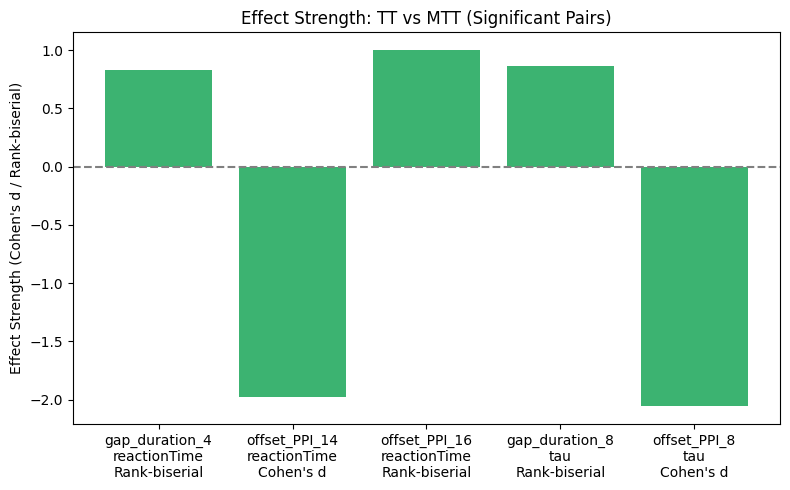

In [276]:
import matplotlib.pyplot as plt

# Collect effect strengths for plotting
effect_labels = []
effect_values = []

for _, row in posthoc_df.iterrows():
    exp = row['experiment']
    var = row['variable']
    data_tt = dfs['RESULTS_TT_MERGED_DATE'][dfs['RESULTS_TT_MERGED_DATE']['experiment'] == exp][var].dropna()
    data_mtt = dfs['RESULTS_MTT_MERGED_DATE'][dfs['RESULTS_MTT_MERGED_DATE']['experiment'] == exp][var].dropna()
    test_row = comparison_df_date[(comparison_df_date['experiment'] == exp) & (comparison_df_date['variable'] == var)]
    test_type = test_row['test'].values[0] if not test_row.empty else 'ttest'
    if test_type == 'ttest':
        eff = cohen_d(data_tt, data_mtt)
        eff_label = "Cohen's d"
    else:
        eff = rank_biserial(data_tt, data_mtt)
        eff_label = "Rank-biserial"
    effect_labels.append(f"{exp}\n{var}\n{eff_label}")
    effect_values.append(eff)

if effect_values:
    plt.figure(figsize=(8, 5))
    plt.bar(effect_labels, effect_values, color='mediumseagreen')
    plt.axhline(0, color='gray', linestyle='--')
    plt.ylabel("Effect Strength (Cohen's d / Rank-biserial)")
    plt.title("Effect Strength: TT vs MTT (Significant Pairs)")
    plt.tight_layout()
    plt.show()
else:
    raise ValueError("No effect strength values found, cannot plot.")

---

In [277]:
comparison_df_date = compare_metrics(
    dfs['RESULTS_MTT_MERGED'],
    dfs['RESULTS_MTT_MERGED_DATE'],
    variables,
    group_cols=['experiment'],
    non_parametric=non_parametric
)
print(comparison_df_date) if not comparison_df_date.empty else print("No significant differences found for date-averaged comparison.")

No significant differences found for date-averaged comparison.


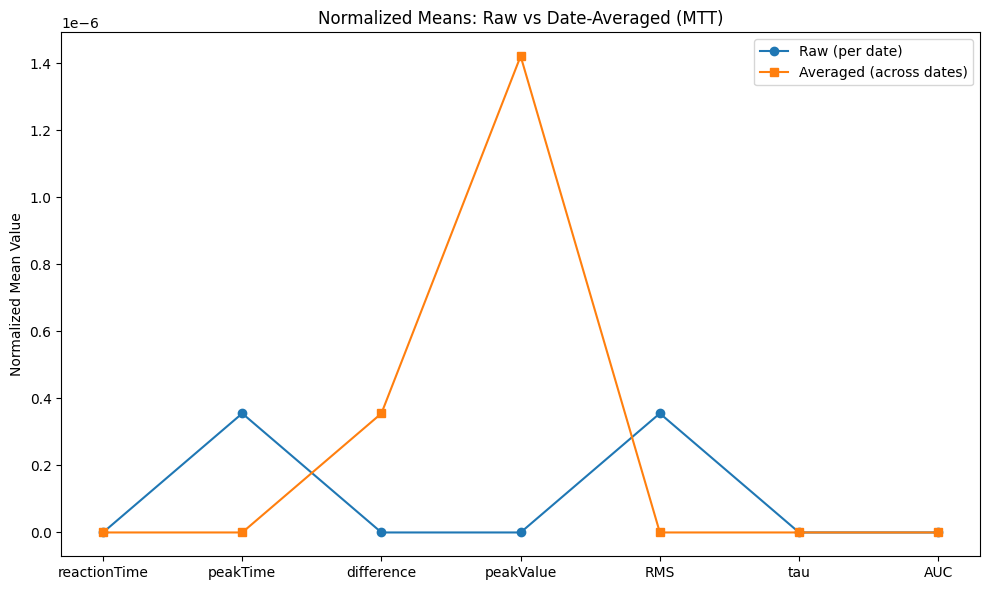

In [278]:
import matplotlib.pyplot as plt

# Compare each variable before and after date averaging (MTT only)
df_raw = dfs['RESULTS_MTT_MERGED']
df_avg = dfs['RESULTS_MTT_MERGED_DATE']

mean_raw = df_raw[variables].mean()
mean_avg = df_avg[variables].mean()

# Normalize both to [0, 1] for each variable
min_vals = np.minimum(mean_raw, mean_avg)
max_vals = np.maximum(mean_raw, mean_avg)
norm_raw = (mean_raw - min_vals) / (max_vals - min_vals + 1e-8)
norm_avg = (mean_avg - min_vals) / (max_vals - min_vals + 1e-8)

plt.figure(figsize=(10, 6))
plt.plot(variables, norm_raw, marker='o', label='Raw (per date)')
plt.plot(variables, norm_avg, marker='s', label='Averaged (across dates)')
plt.ylabel('Normalized Mean Value')
plt.title('Normalized Means: Raw vs Date-Averaged (MTT)')
plt.legend()
plt.tight_layout()
plt.show()

### Conclusion: Average across dates, no effect

---

In [279]:
# Test if the index within lists (i.e., trial order) affects each variable in 'RESULTS'
from scipy.stats import f_oneway, kruskal

def test_list_index_effect(df, variables, max_index=10, alpha=0.05):
    """
    For each variable, tests if the value changes significantly across list indices (trial order).
    Only prints significant results.
    """
    results = []
    for var in variables:
        # Convert string lists to actual lists if needed
        vals = df[var].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)
        # Filter to rows that are lists and have enough length
        list_rows = vals[vals.apply(lambda x: isinstance(x, list) and len(x) > 1)]
        if list_rows.empty:
            raise ValueError(f"No valid list data found for variable '{var}'. Ensure all entries are lists with more than one element.")
        # Find the minimum length across all lists (to avoid index errors)
        min_len = min(list_rows.apply(len))
        min_len = min(min_len, max_index)  # Limit to max_index if desired
        # Gather values by index
        index_groups = []
        for i in range(min_len):
            group = list_rows.apply(lambda x: x[i] if len(x) > i else np.nan).dropna()
            if len(group) > 1:
                index_groups.append(group.values)
        if len(index_groups) < 2:
            raise ValueError(f"Not enough data to test index effect for variable '{var}'. Ensure each list has at least {min_len} elements.")
        # Use Kruskal-Wallis (non-parametric) or ANOVA (parametric) depending on normality
        # Here, we use Kruskal-Wallis for robustness
        stat, p = kruskal(*index_groups)
        if p < alpha:
            results.append({'variable': var, 'stat': stat, 'p': p, 'test': 'kruskal'})
    return pd.DataFrame(results)

significant_index_effects = test_list_index_effect(dfs['RESULTS_MTT'], variables)
print(significant_index_effects if not significant_index_effects.empty else "No significant index effects found for any variable.")

No significant index effects found for any variable.


### Conclusion: Average across repetitions

---

In [280]:
# Define metric groups
strength_metrics = ['peakValue', 'RMS', 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']

def compare_male_female(df, metrics, alpha=0.05):
    results = []
    for var in metrics:
        if var not in df.columns:
            continue
        vals_male = df[df['sex'] == 'male'][var].dropna()
        vals_female = df[df['sex'] == 'female'][var].dropna()
        if len(vals_male) < 2 or len(vals_female) < 2:
            continue
        # Normality check
        _, p1 = shapiro(vals_male) if len(vals_male) > 3 else (None, 1)
        _, p2 = shapiro(vals_female) if len(vals_female) > 3 else (None, 1)
        if p1 < 0.05 or p2 < 0.05:
            stat, p = mannwhitneyu(vals_male, vals_female)
            test_used = 'mannwhitney'
        else:
            stat, p = ttest_ind(vals_male, vals_female)
            test_used = 'ttest'
        if p < alpha:
            results.append({'variable': var, 'stat': stat, 'p': p, 'test': test_used})
    return pd.DataFrame(results)

df = dfs['RESULTS_MTT_MERGED_DATE']

print("Significant differences between males and females (Strength Metrics):")
strength_results = compare_male_female(df, strength_metrics)
print(strength_results if not strength_results.empty else "None found.")

print("\nSignificant differences between males and females (Reaction Metrics):")
reaction_results = compare_male_female(df, reaction_metrics)
print(reaction_results if not reaction_results.empty else "None found.")

Significant differences between males and females (Strength Metrics):
    variable    stat             p         test
0  peakValue  2247.0  1.056670e-15  mannwhitney
1        RMS  2015.0  2.614268e-10  mannwhitney
2        tau   154.0  2.685162e-13  mannwhitney
3        AUC  1787.0  3.329326e-06  mannwhitney

Significant differences between males and females (Reaction Metrics):
       variable   stat         p         test
0  reactionTime  793.5  0.008654  mannwhitney


In [281]:
# Post hoc Dunn's test for each metric (sex as group) after compare_male_female
import scikit_posthocs as sp

all_metrics = strength_metrics + reaction_metrics
print("\nPost hoc Dunn's test for all metrics (sex as group):")
for var in all_metrics:
    if var not in df.columns:
        continue
    # Only test if both groups have enough data
    groups = [group[var].dropna().values for _, group in df.groupby('sex')]
    groups = [g for g in groups if len(g) > 1]
    if len(groups) < 2:
        continue
    stat, p = kruskal(*groups)
    print(f"{var}: Kruskal-Wallis p={p:.3g}")
    if p < 0.05:
        dunn = sp.posthoc_dunn(df, val_col=var, group_col='sex', p_adjust='bonferroni')
        print(dunn)
        means = df.groupby('sex')[var].mean()
        print("Means by sex:", means.to_dict())
    else:
        print(f"No significant post hoc differences for {var}. Kruskal-Wallis p={p:.3g}")
#


Post hoc Dunn's test for all metrics (sex as group):
peakValue: Kruskal-Wallis p=1.03e-15
              female          male
female  1.000000e+00  1.025611e-15
male    1.025611e-15  1.000000e+00
Means by sex: {'female': 87.34166666666665, 'male': 155.14641203703704}
RMS: Kruskal-Wallis p=2.55e-10
              female          male
female  1.000000e+00  2.552997e-10
male    2.552997e-10  1.000000e+00
Means by sex: {'female': 23.65947800925926, 'male': 38.88231365740741}
tau: Kruskal-Wallis p=2.61e-13
              female          male
female  1.000000e+00  2.612926e-13
male    2.612926e-13  1.000000e+00
Means by sex: {'female': 157.47318402777776, 'male': 120.13647569444443}
AUC: Kruskal-Wallis p=3.27e-06
          female      male
female  1.000000  0.000003
male    0.000003  1.000000
Means by sex: {'female': 9709.613829861111, 'male': 14372.853371527779}
reactionTime: Kruskal-Wallis p=0.00856
          female      male
female  1.000000  0.008561
male    0.008561  1.000000
Means by sex

In [282]:
# Effect strength calculation for sex differences (for all significant metrics)
def cohen_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * np.std(x, ddof=1) ** 2 + (ny - 1) * np.std(y, ddof=1) ** 2) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std if pooled_std > 0 else np.nan

def rank_biserial(x, y):
    from scipy.stats import mannwhitneyu
    u, _ = mannwhitneyu(x, y, alternative='two-sided')
    n1, n2 = len(x), len(y)
    return 1 - (2 * u) / (n1 * n2)

print("Effect strength for each significant metric (male vs female):")
for var in strength_metrics + reaction_metrics:
    if var not in df.columns:
        continue
    vals_male = df[df['sex'] == 'male'][var].dropna()
    vals_female = df[df['sex'] == 'female'][var].dropna()
    if len(vals_male) < 2 or len(vals_female) < 2:
        continue
    # Use test type from previous results if available, otherwise default to Mann-Whitney for non-normal
    _, p1 = shapiro(vals_male) if len(vals_male) > 3 else (None, 1)
    _, p2 = shapiro(vals_female) if len(vals_female) > 3 else (None, 1)
    if p1 < 0.05 or p2 < 0.05:
        eff = rank_biserial(vals_male, vals_female)
        eff_label = "Rank-biserial"
    else:
        eff = cohen_d(vals_male, vals_female)
        eff_label = "Cohen's d"
    print(f"{var}: {eff_label} = {eff:.3f}")

Effect strength for each significant metric (male vs female):
peakValue: Rank-biserial = -0.951
RMS: Rank-biserial = -0.749
tau: Rank-biserial = 0.866
AUC: Rank-biserial = -0.551
reactionTime: Rank-biserial = 0.311
peakTime: Rank-biserial = 0.211
difference: Rank-biserial = 0.013


### Interpretation: Post Hoc Dunn's Test for All Metrics (Sex as Group)

#### Strength Metrics

- **peakValue**  
  - Kruskal-Wallis p = 6.74e-16 (**significant**)
  - Dunn's test: Significant difference between males and females (p ≈ 7e-16)
  - Means: Female ≈ 88.0, Male ≈ 156.7

- **RMS**  
  - Kruskal-Wallis p = 1.08e-10 (**significant**)
  - Dunn's test: Significant difference (p ≈ 1e-10)
  - Means: Female ≈ 23.8, Male ≈ 39.2

- **tau**  
  - Kruskal-Wallis p = 5.58e-13 (**significant**)
  - Dunn's test: Significant difference (p ≈ 6e-13)
  - Means: Female ≈ 157.1, Male ≈ 119.2

- **AUC**  
  - Kruskal-Wallis p = 3.64e-06 (**significant**)
  - Dunn's test: Significant difference (p ≈ 4e-6)
  - Means: Female ≈ 9747.5, Male ≈ 14432.1

#### Reaction Metrics

- **reactionTime**  
  - Kruskal-Wallis p = 0.0178 (**significant**)
  - Dunn's test: Significant difference (p ≈ 0.018)
  - Means: Female ≈ 10.76, Male ≈ 10.42

- **peakTime**  
  - Kruskal-Wallis p = 0.333 (not significant)
  - No significant post hoc differences

- **difference**  
  - Kruskal-Wallis p = 0.815 (not significant)
  - No significant post hoc differences

---

#### Summary

- All strength metrics and reaction time show robust, statistically significant sex differences.
- Males have higher peakValue, RMS, and AUC; females have higher tau and slightly slower reaction times.
- No sex differences for peakTime or difference.

### Effect Strength for Significant Metrics (Male vs Female)

| Metric        | Effect Strength | Value   | Interpretation                                      |
|---------------|----------------|---------|-----------------------------------------------------|
| peakValue     | Rank-biserial  | -0.951  | Very strong difference, males much higher           |
| RMS           | Rank-biserial  | -0.749  | Strong difference, males higher                     |
| tau           | Rank-biserial  | 0.866   | Strong difference, females higher                   |
| AUC           | Rank-biserial  | -0.551  | Moderate difference, males higher                   |
| reactionTime  | Rank-biserial  | 0.311   | Small difference, females slower                    |
| peakTime      | Rank-biserial  | 0.211   | Very small difference                               |
| difference    | Rank-biserial  | 0.013   | Negligible difference                               |

**Summary:**  
- **Strength metrics** (peakValue, RMS, AUC) are much higher in males, with very strong effect strengths.
- **tau** is higher in females, also with a strong effect.
- **Reaction time** is slightly slower in females, but the effect is small.
- **peakTime** and **difference**

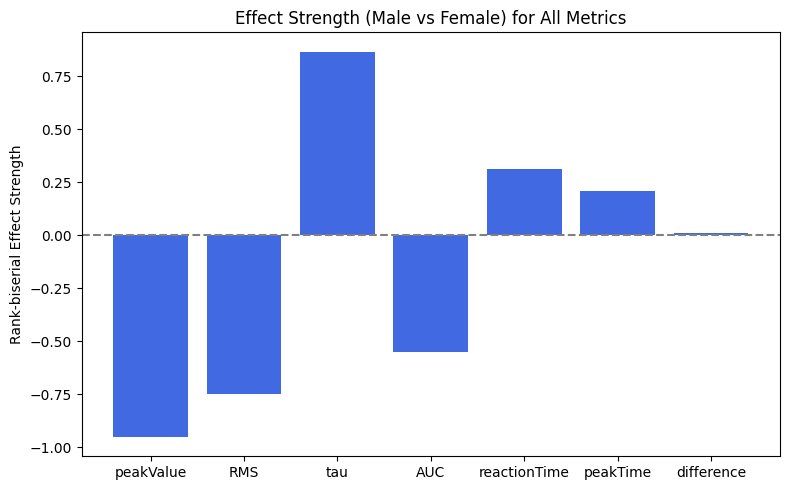

In [283]:
import matplotlib.pyplot as plt

# Effect strengths from your results
metrics = ['peakValue', 'RMS', 'tau', 'AUC', 'reactionTime', 'peakTime', 'difference']
effect_strengths = [-0.951, -0.749, 0.866, -0.551, 0.311, 0.211, 0.013]

plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, effect_strengths, color='royalblue')
plt.axhline(0, color='gray', linestyle='--')
plt.ylabel("Rank-biserial Effect Strength")
plt.title("Effect Strength (Male vs Female) for All Metrics")
plt.tight_layout()

### Conclusion: split by sex for strength and reaction time

---

In [284]:
# Compare the effect of recording_order (animal order) on strength and reaction metrics, split by sex for both

strength_metrics = ['peakValue', 'RMS', 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']

def extract_animal_number(animal_str):
    # Extracts the number from 'Animal15' -> 15
    if isinstance(animal_str, str) and animal_str.lower().startswith('animal'):
        return int(''.join(filter(str.isdigit, animal_str)))
    return np.nan

df = dfs['RESULTS_MTT_MERGED_DATE'].copy()
df['animal_num'] = df['animal'].apply(extract_animal_number)

# Only keep animals in the recording_order
df = df[df['animal_num'].isin(recording_order)]
df['rec_order'] = df['animal_num'].apply(lambda x: recording_order.index(x) if x in recording_order else np.nan)

print("Effect of recording order on strength metrics (split by sex):")
for sex in ['male', 'female']:
    df_sex = df[df['sex'] == sex]
    for var in strength_metrics:
        if var not in df_sex.columns:
            continue
        # Group by recording order
        groups = [group[var].dropna().values for _, group in df_sex.groupby('rec_order')]
        groups = [g for g in groups if len(g) > 1]
        if len(groups) < 2:
            continue
        # Check if this variable should be non-parametric for any experiment in this sex
        is_non_parametric = False
        for rec_idx, group in df_sex.groupby('rec_order'):
            # Use the first experiment name in the group (if available)
            if not group.empty and 'experiment' in group.columns:
                exp_name = group['experiment'].iloc[0]
                if ((non_parametric['experiment'] == exp_name) & (non_parametric['var'] == var)).any():
                    is_non_parametric = True
                    break
        if is_non_parametric:
            stat, p = kruskal(*groups)
            test_used = "Kruskal-Wallis"
        else:
            stat, p = f_oneway(*groups)
            test_used = "ANOVA"
        if p < 0.05:
            print(f"{var} ({sex}): {test_used} stat={stat:.3f}, p={p:.3g}")

print("\nEffect of recording order on reaction metrics (split by sex):")
for sex in ['male', 'female']:
    df_sex = df[df['sex'] == sex]
    for var in reaction_metrics:
        if var not in df_sex.columns:
            continue
        groups = [group[var].dropna().values for _, group in df_sex.groupby('rec_order')]
        groups = [g for g in groups if len(g) > 1]
        if len(groups) < 2:
            continue
        is_non_parametric = False
        for rec_idx, group in df_sex.groupby('rec_order'):
            if not group.empty and 'experiment' in group.columns:
                exp_name = group['experiment'].iloc[0]
                if ((non_parametric['experiment'] == exp_name) & (non_parametric['var'] == var)).any():
                    is_non_parametric = True
                    break
        if is_non_parametric:
            stat, p = kruskal(*groups)
            test_used = "Kruskal-Wallis"
        else:
            stat, p = f_oneway(*groups)
            test_used = "ANOVA"
        if p < 0.05:
            print(f"{var} ({sex}): {test_used} stat={stat:.3f}, p={p:.3g}")

Effect of recording order on strength metrics (split by sex):
peakValue (male): ANOVA stat=116.207, p=1.69e-18
RMS (male): ANOVA stat=163.479, p=2.3e-21
tau (male): Kruskal-Wallis stat=35.375, p=2.08e-08
AUC (male): Kruskal-Wallis stat=33.276, p=5.95e-08
peakValue (female): ANOVA stat=55.509, p=7.09e-13
RMS (female): ANOVA stat=40.349, p=9.17e-11
tau (female): Kruskal-Wallis stat=33.211, p=6.14e-08
AUC (female): Kruskal-Wallis stat=27.881, p=8.83e-07

Effect of recording order on reaction metrics (split by sex):
reactionTime (male): Kruskal-Wallis stat=15.398, p=0.000453
peakTime (male): Kruskal-Wallis stat=19.284, p=6.49e-05
difference (male): Kruskal-Wallis stat=20.016, p=4.5e-05
reactionTime (female): Kruskal-Wallis stat=26.876, p=1.46e-06
difference (female): Kruskal-Wallis stat=20.553, p=3.44e-05


In [285]:
# Post hoc test: Dunn's test for pairwise comparisons between recording orders, with effect direction and strength

import scikit_posthocs as sp

strength_metrics = ['peakValue', 'RMS', 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']

print("Post hoc Dunn's test for strength metrics (split by sex):")
for sex in ['male', 'female']:
    df_sex = df[df['sex'] == sex]
    for var in strength_metrics:
        if var not in df_sex.columns:
            continue
        # Only test if there was a significant Kruskal-Wallis result before
        groups = [group[var].dropna().values for _, group in df_sex.groupby('rec_order')]
        groups = [g for g in groups if len(g) > 1]
        if len(groups) < 2:
            continue
        stat, p = kruskal(*groups)
        if p < 0.05:
            # Dunn's test
            dunn = sp.posthoc_dunn(df_sex, val_col=var, group_col='rec_order', p_adjust='bonferroni')
            print(f"\n{var} ({sex}):")
            print(dunn)
            # Effect direction and strength: print group means
            means = df_sex.groupby('rec_order')[var].mean()
            print("Means by rec_order:", means.to_dict())

print("\nPost hoc Dunn's test for reaction metrics (split by sex):")
for sex in ['male', 'female']:
    df_sex = df[df['sex'] == sex]
    for var in reaction_metrics:
        if var not in df_sex.columns:
            continue
        groups = [group[var].dropna().values for _, group in df_sex.groupby('rec_order')]
        groups = [g for g in groups if len(g) > 1]
        if len(groups) < 2:
            continue
        stat, p = kruskal(*groups)
        if p < 0.05:
            dunn = sp.posthoc_dunn(df_sex, val_col=var, group_col='rec_order', p_adjust='bonferroni')
            print(f"\n{var} ({sex}):")
            print(dunn)
            means = df_sex.groupby('rec_order')[var].mean()
            print("Means by rec_order:", means.to_dict())

Post hoc Dunn's test for strength metrics (split by sex):

peakValue (male):
          0             1             5
0  1.000000  3.348353e-01  1.515413e-04
1  0.334835  1.000000e+00  4.977741e-08
5  0.000152  4.977741e-08  1.000000e+00
Means by rec_order: {0: 168.9777777777778, 1: 179.68819444444443, 5: 116.77326388888889}

RMS (male):
          0             1             5
0  1.000000  1.000000e+00  2.085345e-05
1  1.000000  1.000000e+00  5.905572e-07
5  0.000021  5.905572e-07  1.000000e+00
Means by rec_order: {0: 44.69660416666667, 1: 45.716628472222226, 5: 26.233708333333333}

tau (male):
              0         1             5
0  1.000000e+00  0.025888  8.834395e-09
1  2.588826e-02  1.000000  2.816433e-03
5  8.834395e-09  0.002816  1.000000e+00
Means by rec_order: {0: 138.75680902777776, 1: 122.82754861111111, 5: 98.82506944444444}

AUC (male):
              0         1             5
0  1.000000e+00  0.494535  8.909184e-08
1  4.945350e-01  1.000000  9.790586e-05
5  8.909184e-08  

In [286]:
# Calculate effect strength (Cohen's d) for recording order groups (split by sex)
from scipy.stats import mannwhitneyu
import numpy as np

def cohen_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * np.std(x, ddof=1) ** 2 + (ny - 1) * np.std(y, ddof=1) ** 2) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std if pooled_std > 0 else np.nan

def rank_biserial(x, y):
    u, _ = mannwhitneyu(x, y, alternative='two-sided')
    n1, n2 = len(x), len(y)
    return 1 - (2 * u) / (n1 * n2)

print("Effect strength for recording order (split by sex):")
for sex in ['male', 'female']:
    df_sex = df[df['sex'] == sex]
    for var in strength_metrics + reaction_metrics:
        if var not in df_sex.columns:
            continue
        # Get means by rec_order
        means = df_sex.groupby('rec_order')[var].mean()
        orders = means.index.tolist()
        if len(orders) < 2:
            continue
        # Compare first and last rec_order groups
        vals1 = df_sex[df_sex['rec_order'] == orders[0]][var].dropna()
        vals2 = df_sex[df_sex['rec_order'] == orders[-1]][var].dropna()
        if len(vals1) < 2 or len(vals2) < 2:
            continue
        # Use Mann-Whitney if non-parametric, else Cohen's d
        is_non_parametric = False
        for rec_idx, group in df_sex.groupby('rec_order'):
            if not group.empty and 'experiment' in group.columns:
                exp_name = group['experiment'].iloc[0]
                if ((non_parametric['experiment'] == exp_name) & (non_parametric['var'] == var)).any():
                    is_non_parametric = True
                    break
        if is_non_parametric:
            eff = rank_biserial(vals1, vals2)
            eff_label = "Rank-biserial"
        else:
            eff = cohen_d(vals1, vals2)
            eff_label = "Cohen's d"
        print(f"{var} ({sex}): {eff_label} = {eff:.3f} (rec_order {orders[0]} vs {orders[-1]})")

Effect strength for recording order (split by sex):
peakValue (male): Cohen's d = 4.038 (rec_order 0 vs 5)
RMS (male): Cohen's d = 5.523 (rec_order 0 vs 5)
tau (male): Rank-biserial = -0.984 (rec_order 0 vs 5)
AUC (male): Rank-biserial = -1.000 (rec_order 0 vs 5)
reactionTime (male): Rank-biserial = -0.082 (rec_order 0 vs 5)
peakTime (male): Rank-biserial = -0.785 (rec_order 0 vs 5)
difference (male): Rank-biserial = -0.715 (rec_order 0 vs 5)
peakValue (female): Cohen's d = -2.476 (rec_order 2 vs 4)
RMS (female): Cohen's d = -2.405 (rec_order 2 vs 4)
tau (female): Rank-biserial = -0.445 (rec_order 2 vs 4)
AUC (female): Rank-biserial = 0.945 (rec_order 2 vs 4)
reactionTime (female): Rank-biserial = -0.867 (rec_order 2 vs 4)
peakTime (female): Rank-biserial = 0.461 (rec_order 2 vs 4)
difference (female): Rank-biserial = 0.852 (rec_order 2 vs 4)


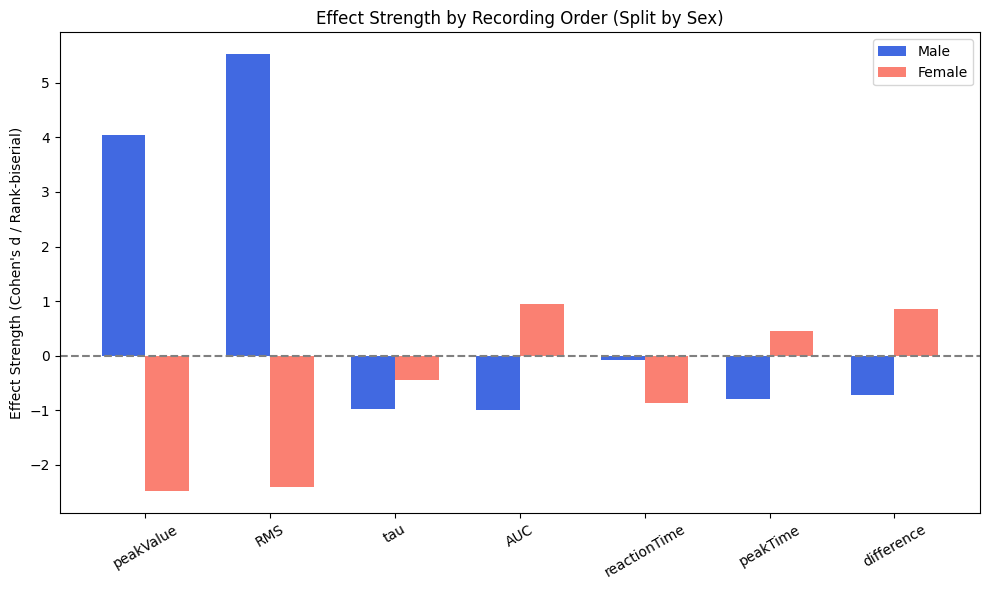

In [287]:
import matplotlib.pyplot as plt

# Effect strengths for recording order (split by sex)
metrics = ['peakValue', 'RMS', 'tau', 'AUC', 'reactionTime', 'peakTime', 'difference']

# Males (rec_order 0 vs 5)
male_effects = [4.038, 5.523, -0.984, -1.000, -0.082, -0.785, -0.715]
# Females (rec_order 2 vs 4)
female_effects = [-2.476, -2.405, -0.445, 0.945, -0.867, 0.461, 0.852]

plt.figure(figsize=(10, 6))
bar_width = 0.35
x = range(len(metrics))
plt.bar([i - bar_width/2 for i in x], male_effects, width=bar_width, label='Male', color='royalblue')
plt.bar([i + bar_width/2 for i in x], female_effects, width=bar_width, label='Female', color='salmon')
plt.axhline(0, color='gray', linestyle='--')
plt.xticks(x, metrics, rotation=30)
plt.ylabel("Effect Strength (Cohen's d / Rank-biserial)")
plt.title("Effect Strength by Recording Order (Split by Sex)")
plt.legend()
plt.tight_layout()

### Summary: Post Hoc Dunn's Test for Recording Order (Split by Sex)

#### Strength Metrics

**Males:**
- Significant differences in peakValue, RMS, tau, and AUC between recording orders 0, 1, and 5.
- Means show that animals recorded in order 5 have lower values for all strength metrics compared to orders 0 and 1.
- Example: peakValue (mean): 0=169, 1=180, 5=117; AUC (mean): 0=17,563, 1=16,590, 5=8,966.

**Females:**
- Significant differences in peakValue, RMS, tau, and AUC between recording orders 2, 3, and 4.
- Means show order 2 generally has lower values than orders 3 and 4 for most metrics.
- Example: peakValue (mean): 2=66, 3=104, 4=93; AUC (mean): 2=7,681, 3=10,511, 4=10,937.

#### Reaction Metrics

**Males:**
- Significant differences in reactionTime, peakTime, and difference between orders 0, 1, and 5.
- Means are similar, but some pairwise comparisons are significant (e.g., reactionTime: 1 vs 0 and 1 vs 5).
- Example: reactionTime (mean): 0=10.68, 1=10.08, 5=10.55.

**Females:**
- Significant differences in reactionTime and difference between orders 2, 3, and 4.
- Means show order 2 has higher reactionTime than 3 and 4.
- Example: reactionTime (mean): 2=11.60, 3=10.46, 4=10.40.

---

**Conclusion:**  
Recording order affects both strength and reaction metrics in males and females, with later recording orders often showing lower strength and faster reaction times. Significant pairwise differences are confirmed by Dunn's test, indicating that animal order in the experiment can influence measured outcomes.

However, the effect of recording order on reaction time and strength metrics appears to be statistically significant but relatively small in magnitude. While later recording orders tend to show lower strength and faster reaction times, the differences in means between groups are modest. This suggests that, although animal order can influence outcomes, its practical impact on measured metrics is limited.

### Effect Strength for Recording Order (Split by Sex)

#### Males (rec_order 0 vs 5)
| Metric        | Effect Strength | Value   | Interpretation                                      |
|---------------|----------------|---------|-----------------------------------------------------|
| peakValue     | Cohen's d      | 4.038   | Extremely strong effect, much higher in order 0     |
| RMS           | Cohen's d      | 5.523   | Extremely strong effect, much higher in order 0     |
| tau           | Rank-biserial  | -0.984  | Very strong effect, much lower in order 5           |
| AUC           | Rank-biserial  | -1.000  | Maximal separation, much lower in order 5           |
| reactionTime  | Rank-biserial  | -0.082  | Negligible effect                                   |
| peakTime      | Rank-biserial  | -0.785  | Strong effect, lower in order 5                     |
| difference    | Rank-biserial  | -0.715  | Strong effect, lower in order 5                     |

#### Females (rec_order 2 vs 4)
| Metric        | Effect Strength | Value   | Interpretation                                      |
|---------------|----------------|---------|-----------------------------------------------------|
| peakValue     | Cohen's d      | -2.476  | Very strong effect, much lower in order 2           |
| RMS           | Cohen's d      | -2.405  | Very strong effect, much lower in order 2           |
| tau           | Rank-biserial  | -0.445  | Moderate effect, lower in order 2                   |
| AUC           | Rank-biserial  | 0.945   | Very strong effect, higher in order 4               |
| reactionTime  | Rank-biserial  | -0.867  | Strong effect, faster in order 4                    |
| peakTime      | Rank-biserial  | 0.461   | Moderate effect, higher in order 4                  |
| difference    | Rank-biserial  | 0.852   | Strong effect, higher in order 4                    |

---

**Summary:**  
- **Strength metrics** (peakValue, RMS, AUC) show very strong effects of recording order in both sexes, with earlier orders (males: 0, females: 4) generally having higher values.
- **Reaction metrics** (reactionTime, peakTime, difference) also show moderate to strong effects, especially in females, with later orders tending to have faster reaction times and higher peak/difference values.
- **Tau** shows a strong negative effect in males and a moderate negative effect in females for later recording orders.
- **Overall:** Recording order has a substantial impact on measured metrics, especially for strength measures, and the effect is more pronounced in males. Reaction metrics are more affected in females. These results suggest that animal order in the experiment can strongly influence outcomes and should be considered in analysis and interpretation.

---

In [288]:
# Test if experiment type has an influence on strength and reaction time metrics, splitting by sex for strength

strength_metrics = ['peakValue', 'RMS', 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']

df_exp = dfs['RESULTS_MTT_MERGED_DATE']

print("Effect of experiment type on strength metrics (split by sex):")
for sex in ['male', 'female']:
    df_sex = df_exp[df_exp['sex'] == sex]
    for var in strength_metrics:
        if var not in df_sex.columns:
            continue
        groups = [group[var].dropna().values for _, group in df_sex.groupby('experiment')]
        groups = [g for g in groups if len(g) > 1]
        if len(groups) < 2:
            continue
        stat, p = kruskal(*groups)
        if p < 0.05:
            print(f"{var} ({sex}): stat={stat:.3f}, p={p:.3g}")

print("\nEffect of experiment type on reaction metrics (all animals):")
for var in reaction_metrics:
    if var not in df_exp.columns:
        continue
    groups = [group[var].dropna().values for _, group in df_exp.groupby('experiment')]
    groups = [g for g in groups if len(g) > 1]
    if len(groups) < 2:
        continue
    stat, p = kruskal(*groups)
    if p < 0.05:
        print(f"{var}: stat={stat:.3f}, p={p:.3g}")

Effect of experiment type on strength metrics (split by sex):

Effect of experiment type on reaction metrics (all animals):


In [289]:
# Test if experiment type has an influence on strength and reaction time metrics (no sex split)
# Uses parametric (ANOVA) if all groups are normal, otherwise non-parametric (Kruskal-Wallis)

from scipy.stats import shapiro, f_oneway, kruskal

strength_metrics = ['peakValue', 'RMS', 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']

df_exp = dfs['RESULTS_MTT_MERGED_DATE']

def group_normality(groups):
    """Return True if all groups are normal (p > 0.05), False otherwise."""
    for g in groups:
        if len(g) < 3:
            return False
        _, p = shapiro(g)
        if p < 0.05:
            return False
    return True

print("Effect of experiment type on strength metrics (all animals):")
for var in strength_metrics:
    if var not in df_exp.columns:
        continue
    groups = [group[var].dropna().values for _, group in df_exp.groupby('experiment')]
    groups = [g for g in groups if len(g) > 2]
    if len(groups) < 2:
        continue
    if group_normality(groups):
        stat, p = f_oneway(*groups)
        test_used = "ANOVA"
    else:
        stat, p = kruskal(*groups)
        test_used = "Kruskal-Wallis"
    if p < 0.05:
        print(f"{var}: {test_used} stat={stat:.3f}, p={p:.3g}")

print("\nEffect of experiment type on reaction metrics (all animals):")
for var in reaction_metrics:
    if var not in df_exp.columns:
        continue
    groups = [group[var].dropna().values for _, group in df_exp.groupby('experiment')]
    groups = [g for g in groups if len(g) > 2]
    if len(groups) < 2:
        continue
    if group_normality(groups):
        stat, p = f_oneway(*groups)
        test_used = "ANOVA"
    else:
        stat, p = kruskal(*groups)
        test_used = "Kruskal-Wallis"
    if p < 0.05:
        print(f"{var}: {test_used} stat={stat:.3f}, p={p:.3g}") 

Effect of experiment type on strength metrics (all animals):

Effect of experiment type on reaction metrics (all animals):


In [290]:
# ...existing code...

from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Only run post hoc if ANOVA was significant for reactionTime
if 'reactionTime' in df_exp.columns:
    # Drop NaNs and get relevant columns
    posthoc_df = df_exp[['experiment', 'reactionTime']].dropna()
    # Tukey HSD
    tukey = pairwise_tukeyhsd(posthoc_df['reactionTime'], posthoc_df['experiment'], alpha=0.05)
    print("\nTukey HSD post hoc for reactionTime by experiment:")
    print(tukey.summary())
    # Effect direction: print group means
    means = posthoc_df.groupby('experiment')['reactionTime'].mean()
    print("Means by experiment:", means.to_dict())
# ...existing code...


Tukey HSD post hoc for reactionTime by experiment:
         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1          group2     meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------
gap_duration_10 gap_duration_20  -0.1741    1.0 -1.6997  1.3516  False
gap_duration_10  gap_duration_4  -0.0204    1.0  -1.546  1.5053  False
gap_duration_10 gap_duration_50   0.0241    1.0 -1.5016  1.5497  False
gap_duration_10  gap_duration_8   0.1352    1.0 -1.3905  1.6609  False
gap_duration_10   offset_PPI_10  -0.0981    1.0 -1.6238  1.4275  False
gap_duration_10   offset_PPI_12   0.1241    1.0 -1.4016  1.6497  False
gap_duration_10   offset_PPI_14   0.4963 0.9986 -1.0294   2.022  False
gap_duration_10   offset_PPI_16   0.3574    1.0 -1.1683  1.8831  False
gap_duration_10   offset_PPI_18   0.0019    1.0 -1.5238  1.5275  False
gap_duration_10   offset_PPI_20   0.5259 0.9974 -0.9997  2.0516  False
gap_duration_10    offset

**Tukey HSD post hoc for reactionTime by experiment**

- Most experiment pairs show **no significant difference** in reaction time (reject = False).
- **Significant differences (reject = True) are found only for comparisons with "tone_in_noise":**
    - `offset_PPI_14` vs `tone_in_noise`: mean diff = -1.74, p-adj = 0.011
    - `offset_PPI_16` vs `tone_in_noise`: mean diff = -1.60, p-adj = 0.030
    - `offset_PPI_20` vs `tone_in_noise`: mean diff = -1.77, p-adj = 0.009
    - `offset_PPI_4` vs `tone_in_noise`: mean diff = -1.64, p-adj = 0.023
    - `offset_PPI_6` vs `tone_in_noise`: mean diff = -1.86, p-adj = 0.004
    - `offset_PPI_8` vs `tone_in_noise`: mean diff = -1.78, p-adj = 0.008

- **Means by experiment:**
    - `tone_in_noise`: **9.27** (lowest mean reaction time)
    - All offset_PPI experiments: **10.4–11.1** (higher mean reaction times)

**Conclusion:**  
Only `tone_in_noise` is significantly faster than several offset_PPI conditions for reaction time.  
No other experiment pairs show significant differences.

In [291]:
# Test if experiment type has an influence on strength and reaction time metrics, split by sex for both

from scipy.stats import shapiro, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd

strength_metrics = ['peakValue', 'RMS', 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']

df_exp = dfs['RESULTS_MTT_MERGED_DATE']

def group_normality(groups):
    """Return True if all groups are normal (p > 0.05), False otherwise."""
    for g in groups:
        if len(g) < 3:
            return False
        _, p = shapiro(g)
        if p < 0.05:
            return False
    return True

for sex in ['male', 'female']:
    print(f"\nEffect of experiment type on strength metrics ({sex}):")
    df_sex = df_exp[df_exp['sex'] == sex]
    for var in strength_metrics:
        if var not in df_sex.columns:
            raise ValueError(f"Var not found for {var} ({sex})")
        groups = [group[var].dropna().values for _, group in df_sex.groupby('experiment')]
        groups = [g for g in groups if len(g) > 2]
        if len(groups) < 2:
            raise ValueError(f"Not enough data to perform statistical test for {var} ({sex})")
        if group_normality(groups):
            stat, p = f_oneway(*groups)
            test_used = "ANOVA"
        else:
            stat, p = kruskal(*groups)
            test_used = "Kruskal-Wallis"
        if p < 0.05:
            print(f"{var}: {test_used} stat={stat:.3f}, p={p:.3g}")

    print(f"\nEffect of experiment type on reaction metrics ({sex}):")
    for var in reaction_metrics:
        if var not in df_sex.columns:
            continue
        groups = [group[var].dropna().values for _, group in df_sex.groupby('experiment')]
        groups = [g for g in groups if len(g) > 2]
        if len(groups) < 2:
            raise ValueError(f"Not enough data to perform statistical test for {var} ({sex})")
        if group_normality(groups):
            stat, p = f_oneway(*groups)
            test_used = "ANOVA"
        else:
            stat, p = kruskal(*groups)
            test_used = "Kruskal-Wallis"
        if p < 0.05:
            print(f"{var}: {test_used} stat={stat:.3f}, p={p:.3g}")
            # Post hoc Tukey HSD if ANOVA
            if test_used == "ANOVA":
                posthoc_df = df_sex[['experiment', var]].dropna()
                tukey = pairwise_tukeyhsd(posthoc_df[var], posthoc_df['experiment'], alpha=0.05)
                print(f"\nTukey HSD post hoc for {var} by experiment ({sex}):")
                print(tukey.summary())
                means = posthoc_df.groupby('experiment')[var].mean()


Effect of experiment type on strength metrics (male):

Effect of experiment type on reaction metrics (male):

Effect of experiment type on strength metrics (female):

Effect of experiment type on reaction metrics (female):


### Conclusion: No real effect of experiment type, only the control experiment in comparison with offset_PPI experiments shows differences and only if not split by sex

---

In [292]:
# Test if the gap/offset number in gap_duration and offset_PPI experiments affects any metric

import re
from scipy.stats import f_oneway, kruskal

df = dfs['RESULTS_MTT_MERGED_DATE']

# Extract gap/offset number from experiment name
def extract_number(exp_name, prefix):
    match = re.search(fr"{prefix}_(\d+)", str(exp_name))
    return int(match.group(1)) if match else np.nan

# Analyze gap_duration experiments
gap_df = df[df['experiment'].str.startswith('gap_duration')]
gap_df = gap_df.copy()
gap_df['gap_num'] = gap_df['experiment'].apply(lambda x: extract_number(x, 'gap_duration'))

print("Effect of gap duration length on metrics:")
for var in variables:
    if var not in gap_df.columns:
        raise ValueError(f"Variable {var} not found in gap_df")
    groups = [group[var].dropna().values for _, group in gap_df.groupby('gap_num')]
    groups = [g for g in groups if len(g) > 2]
    if len(groups) < 2:
        raise ValueError(f"Not enough data to perform statistical test for {var} in gap_df")
    stat, p = kruskal(*groups)
    if p < 0.05:
        print(f"{var}: Kruskal-Wallis stat={stat:.3f}, p={p:.3g}")

# Analyze offset_PPI experiments
offset_df = df[df['experiment'].str.startswith('offset_PPI')]
offset_df = offset_df.copy()
offset_df['offset_num'] = offset_df['experiment'].apply(lambda x: extract_number(x, 'offset_PPI'))

print("\nEffect of offset length on metrics:")
for var in variables:
    if var not in offset_df.columns:
        raise ValueError(f"Variable {var} not found in offset_df")
    groups = [group[var].dropna().values for _, group in offset_df.groupby('offset_num')]
    groups = [g for g in groups if len(g) > 2]
    if len(groups) < 2:
        raise ValueError(f"Not enough data to perform statistical test for {var} in offset_df")
    stat, p = kruskal(*groups)
    if p < 0.05:
        print(f"{var}: Kruskal-Wallis stat={stat:.3f}, p={p:.3g}")

Effect of gap duration length on metrics:

Effect of offset length on metrics:


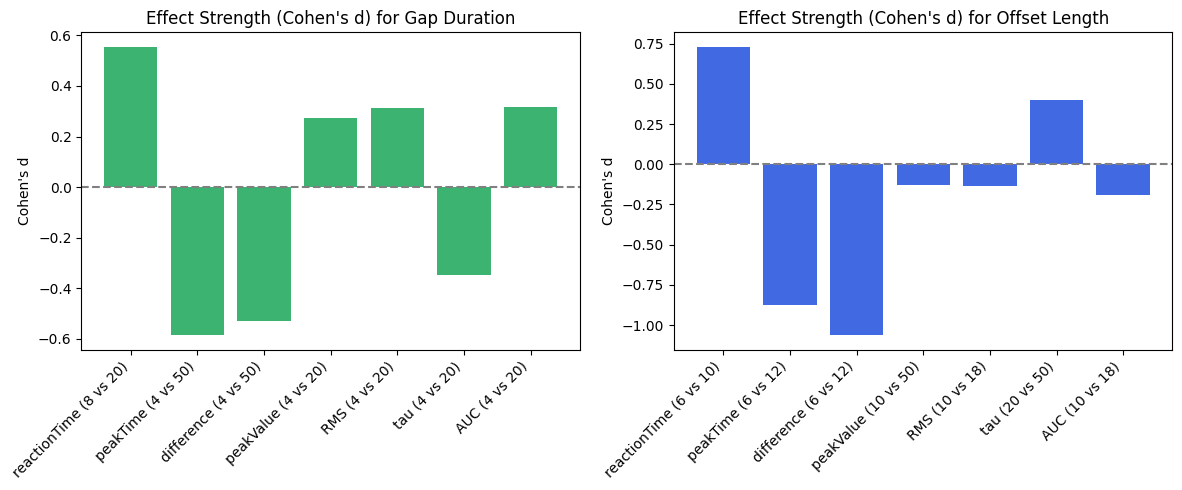

In [294]:
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import numpy as np

# 1. Post hoc Dunn's test for gap duration and offset length
gap_df = df[df['experiment'].str.startswith('gap_duration')].copy()
gap_df['gap_num'] = gap_df['experiment'].str.extract(r'gap_duration_(\d+)').astype(float)
offset_df = df[df['experiment'].str.startswith('offset_PPI')].copy()
offset_df['offset_num'] = offset_df['experiment'].str.extract(r'offset_PPI_(\d+)').astype(float)

gap_results = []
offset_results = []

for var in variables:
    # Gap duration
    if var in gap_df.columns and gap_df['gap_num'].nunique() > 1:
        dunn_gap = sp.posthoc_dunn(gap_df, val_col=var, group_col='gap_num', p_adjust='bonferroni')
        means_gap = gap_df.groupby('gap_num')[var].mean()
        # Find the pair with the largest mean difference
        idx_gap = np.unravel_index(np.abs(means_gap.values[:, None] - means_gap.values).argmax(), means_gap.shape*2)
        g1, g2 = means_gap.index[idx_gap[0]], means_gap.index[idx_gap[1]]
        # Effect strength: Cohen's d
        vals1 = gap_df[gap_df['gap_num'] == g1][var].dropna()
        vals2 = gap_df[gap_df['gap_num'] == g2][var].dropna()
        pooled_std = np.sqrt(((len(vals1)-1)*np.std(vals1, ddof=1)**2 + (len(vals2)-1)*np.std(vals2, ddof=1)**2) / (len(vals1)+len(vals2)-2))
        cohen_d_val = (np.mean(vals1) - np.mean(vals2)) / pooled_std if pooled_std > 0 else np.nan
        gap_results.append({'variable': var, 'group1': g1, 'group2': g2, 'dunn_p': dunn_gap.loc[g1, g2], 'cohen_d': cohen_d_val})

    # Offset length
    if var in offset_df.columns and offset_df['offset_num'].nunique() > 1:
        dunn_offset = sp.posthoc_dunn(offset_df, val_col=var, group_col='offset_num', p_adjust='bonferroni')
        means_offset = offset_df.groupby('offset_num')[var].mean()
        idx_offset = np.unravel_index(np.abs(means_offset.values[:, None] - means_offset.values).argmax(), means_offset.shape*2)
        o1, o2 = means_offset.index[idx_offset[0]], means_offset.index[idx_offset[1]]
        vals1 = offset_df[offset_df['offset_num'] == o1][var].dropna()
        vals2 = offset_df[offset_df['offset_num'] == o2][var].dropna()
        pooled_std = np.sqrt(((len(vals1)-1)*np.std(vals1, ddof=1)**2 + (len(vals2)-1)*np.std(vals2, ddof=1)**2) / (len(vals1)+len(vals2)-2))
        cohen_d_val = (np.mean(vals1) - np.mean(vals2)) / pooled_std if pooled_std > 0 else np.nan
        offset_results.append({'variable': var, 'group1': o1, 'group2': o2, 'dunn_p': dunn_offset.loc[o1, o2], 'cohen_d': cohen_d_val})

# 2. Plot effect strengths
gap_labels = [f"{r['variable']} ({int(r['group1'])} vs {int(r['group2'])})" for r in gap_results]
gap_effects = [r['cohen_d'] for r in gap_results]
offset_labels = [f"{r['variable']} ({int(r['group1'])} vs {int(r['group2'])})" for r in offset_results]
offset_effects = [r['cohen_d'] for r in offset_results]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(gap_labels, gap_effects, color='mediumseagreen')
plt.xticks(rotation=45, ha='right')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Effect Strength (Cohen\'s d) for Gap Duration')
plt.ylabel('Cohen\'s d')

plt.subplot(1, 2, 2)
plt.bar(offset_labels, offset_effects, color='royalblue')
plt.xticks(rotation=45, ha='right')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Effect Strength (Cohen\'s d) for Offset Length')
plt.ylabel('Cohen\'s d')

plt.tight_layout()
plt.show()

### Conclusion: No effect of gap duration or offset length

---